# Model Training and Evaluation

This notebook loads the preprocessed shot data, trains several xG models (with and without geometry features), and evaluates them against actual goals and the StatsBomb xG values.

## Imports

In [38]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, brier_score_loss

from xgboost import XGBClassifier

import matplotlib.pyplot as plt


## Load preprocessed shots

In [39]:
# world cup 2018 data frame
data_path = Path("shots_featured_wc2018.csv")
shots_featured = pd.read_csv(data_path)
display(shots_featured.head())

# Euro 2020 data frame

eu_data_path = Path("shots_featured_eu2020.csv")
shots_eu = pd.read_csv(eu_data_path)
display(shots_eu.head())


# WC 2022 data frame

WC_22_data_path = Path("shots_WC_22.csv")
shots_WC_22 = pd.read_csv(WC_22_data_path)
display(shots_WC_22)

,shot_statsbomb_xg,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,is_goal,distance,angle
0,0.009816,62.0,93.0,40.0,0,0,0,0,115.0,18.0,0,22.561028,0.064071
1,0.038204,87.0,93.0,40.0,0,0,0,0,112.0,54.0,0,16.124515,0.202196
2,0.045128,87.0,93.0,40.0,0,0,0,0,98.0,37.0,0,22.203603,0.283785
3,0.625074,87.0,93.0,37.0,1,0,0,0,119.0,36.0,0,4.123106,0.758049
4,0.021760,87.0,93.0,40.0,0,0,0,0,97.0,56.0,0,28.017851,0.187756


,shot_statsbomb_xg,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,is_goal,distance,angle
0,0.030169,87.0,93.0,38.0,0,0,0,0,91.9,39.0,0,28.117788,0.226500
1,0.021315,87.0,91.0,38.0,0,1,0,0,96.5,29.7,0,25.658137,0.228027
2,0.047888,62.0,93.0,40.0,0,0,0,0,97.8,25.9,0,26.299240,0.205564
3,0.100356,87.0,93.0,37.0,0,0,0,0,112.0,40.7,0,8.030567,0.756483
4,0.008758,87.0,93.0,38.0,0,0,0,0,99.7,58.6,0,27.532708,0.172017


,shot_statsbomb_xg,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,is_goal,distance,angle
0,0.036566,87.0,91.0,38.0,0,1,0,0,96.0,38.8,0,24.029981,0.264461
1,0.353289,87.0,91.0,38.0,0,1,0,0,113.1,40.7,0,6.935416,0.862058
2,0.069527,87.0,91.0,40.0,0,1,0,0,103.8,41.9,0,16.311039,0.385068
3,0.081609,87.0,93.0,37.0,0,0,0,0,112.2,36.8,0,8.430896,0.687124
4,0.030002,87.0,93.0,38.0,0,0,0,0,97.8,51.5,0,25.001800,0.227095
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,0.568312,87.0,93.0,37.0,0,0,0,0,118.2,43.9,0,4.295346,0.951615
1447,0.028724,87.0,93.0,40.0,0,0,0,0,102.5,24.2,0,23.577320,0.202448
1448,0.145394,87.0,93.0,37.0,0,0,0,1,114.4,36.8,0,6.449806,0.851966
1449,0.028684,87.0,93.0,40.0,0,0,0,0,95.0,30.2,0,26.852188,0.221408


## Define target and feature sets

We keep `shot_statsbomb_xg` and `is_goal` for evaluation. We build two feature matrices:

- **Raw features** (`X_raw`): all features *except* distance and angle (this mimics your early models).
- **Featured geometry** (`X_feat`): all features including distance and angle.

In [40]:
# Target
y = shots_featured["is_goal"].astype(int) # world cup data target
y_eu = shots_eu["is_goal"] # Euro data target 
y_wc_22 = shots_WC_22["is_goal"]

# Base feature set (drop labels/statsbomb xg)
X_full = shots_featured.drop(["shot_statsbomb_xg", "is_goal"], axis=1)

X_full_eu = shots_eu.drop(["shot_statsbomb_xg","is_goal"],axis=1)

X_full_wc_22 = shots_WC_22.drop(["shot_statsbomb_xg","is_goal"],axis=1)

# Raw features: no distance & angle
drop_geom = [col for col in ["distance", "angle"] if col in X_full.columns]
X_raw = X_full.drop(drop_geom, axis=1)


X_raw_eu = X_full_eu.drop(["distance","angle"],axis=1)

X_raw_wc_22 = X_full_wc_22.drop(["distance","angle"],axis=1)

# Featured geometry = all features
X_feat = X_full.copy()

X_feat_eu = X_full_eu

X_feat_wc_22 = X_full_wc_22

display(X_raw.head(), X_feat.head(), X_raw_eu.head(), X_feat_eu.head(),X_raw_wc_22.head(),X_feat_wc_22.head())


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y
0,62.0,93.0,40.0,0,0,0,0,115.0,18.0
1,87.0,93.0,40.0,0,0,0,0,112.0,54.0
2,87.0,93.0,40.0,0,0,0,0,98.0,37.0
3,87.0,93.0,37.0,1,0,0,0,119.0,36.0
4,87.0,93.0,40.0,0,0,0,0,97.0,56.0


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,distance,angle
0,62.0,93.0,40.0,0,0,0,0,115.0,18.0,22.561028,0.064071
1,87.0,93.0,40.0,0,0,0,0,112.0,54.0,16.124515,0.202196
2,87.0,93.0,40.0,0,0,0,0,98.0,37.0,22.203603,0.283785
3,87.0,93.0,37.0,1,0,0,0,119.0,36.0,4.123106,0.758049
4,87.0,93.0,40.0,0,0,0,0,97.0,56.0,28.017851,0.187756


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y
0,87.0,93.0,38.0,0,0,0,0,91.9,39.0
1,87.0,91.0,38.0,0,1,0,0,96.5,29.7
2,62.0,93.0,40.0,0,0,0,0,97.8,25.9
3,87.0,93.0,37.0,0,0,0,0,112.0,40.7
4,87.0,93.0,38.0,0,0,0,0,99.7,58.6


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,distance,angle
0,87.0,93.0,38.0,0,0,0,0,91.9,39.0,28.117788,0.226500
1,87.0,91.0,38.0,0,1,0,0,96.5,29.7,25.658137,0.228027
2,62.0,93.0,40.0,0,0,0,0,97.8,25.9,26.299240,0.205564
3,87.0,93.0,37.0,0,0,0,0,112.0,40.7,8.030567,0.756483
4,87.0,93.0,38.0,0,0,0,0,99.7,58.6,27.532708,0.172017


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y
0,87.0,91.0,38.0,0,1,0,0,96.0,38.8
1,87.0,91.0,38.0,0,1,0,0,113.1,40.7
2,87.0,91.0,40.0,0,1,0,0,103.8,41.9
3,87.0,93.0,37.0,0,0,0,0,112.2,36.8
4,87.0,93.0,38.0,0,0,0,0,97.8,51.5


,shot_type_id,shot_technique_id,shot_body_part_id,shot_open_goal,shot_first_time,shot_one_on_one,shot_aerial_won,x,y,distance,angle
0,87.0,91.0,38.0,0,1,0,0,96.0,38.8,24.029981,0.264461
1,87.0,91.0,38.0,0,1,0,0,113.1,40.7,6.935416,0.862058
2,87.0,91.0,40.0,0,1,0,0,103.8,41.9,16.311039,0.385068
3,87.0,93.0,37.0,0,0,0,0,112.2,36.8,8.430896,0.687124
4,87.0,93.0,38.0,0,0,0,0,97.8,51.5,25.001800,0.227095


## Train/test split (shared indices)

We split once using `X_feat` and `y`, then use the resulting indices to build matching train/test sets for `X_raw`.


In [41]:
X_train_feat, X_test_feat, y_train, y_test = train_test_split(
    X_feat, y, test_size=0.2, random_state=42
)

# Align raw feature splits using the same indices
X_train_raw = X_raw.loc[X_train_feat.index]
X_test_raw = X_raw.loc[X_test_feat.index]

X_train_feat.shape, X_train_raw.shape, X_test_feat.shape, X_test_raw.shape


((1333, 11), (1333, 9), (334, 11), (334, 9))

## 1. Logistic Regression (raw features, no geometry)

Logistic regression model based on x, y and categorical/boolean features, without distance and angle.

In [42]:
lr_raw = LogisticRegression(max_iter=2000)
lr_raw.fit(X_train_raw, y_train)

lr_raw_pred_train = lr_raw.predict_proba(X_train_raw)[:, 1]
lr_raw_pred_test = lr_raw.predict_proba(X_test_raw)[:, 1]


## 2. XGBoost (raw features, no geometry)

XGBoost model that only used raw coordinates and simple features.

In [43]:
xgb_raw = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
)

xgb_raw.fit(X_train_raw, y_train)

xgb_raw_pred_train = xgb_raw.predict_proba(X_train_raw)[:, 1]
xgb_raw_pred_test = xgb_raw.predict_proba(X_test_raw)[:, 1]


## 3. Logistic Regression (featured geometry, unscaled)

Lr_featured model: distance and angle included, but no scaling.

In [44]:
lr_featured = LogisticRegression(max_iter=2000)
lr_featured.fit(X_train_feat, y_train)

lr_featured_pred_train = lr_featured.predict_proba(X_train_feat)[:, 1]
lr_featured_pred_test = lr_featured.predict_proba(X_test_feat)[:, 1]


## 4. XGBoost (featured geometry)

Xgb_featured model that uses distance and angle.

In [45]:
xgb_featured = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
)

xgb_featured.fit(X_train_feat, y_train)

xgb_featured_pred_train = xgb_featured.predict_proba(X_train_feat)[:, 1]
xgb_featured_pred_test = xgb_featured.predict_proba(X_test_feat)[:, 1]


## 5. Scaled Logistic Regression (featured geometry)

We standardize all features and then fit logistic regression. This corresponds to the `lr_scaled` model.

In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feat)
X_test_scaled = scaler.transform(X_test_feat)

lr_scaled = LogisticRegression(max_iter=2000)
lr_scaled.fit(X_train_scaled, y_train)

lr_scaled_pred_train = lr_scaled.predict_proba(X_train_scaled)[:, 1]
lr_scaled_pred_test = lr_scaled.predict_proba(X_test_scaled)[:, 1]


## Build comparison dataframe (test set)

We collect StatsBomb xG, actual goals, and predictions from all five models.

In [47]:
comparison_df = pd.DataFrame({
    "shot_statsbomb_xg": shots_featured.loc[X_test_feat.index, "shot_statsbomb_xg"].values,
    "is_goal": y_test.values,
    "lr_raw": lr_raw_pred_test,
    "xgb_raw": xgb_raw_pred_test,
    "lr_featured": lr_featured_pred_test,
    "xgb_featured": xgb_featured_pred_test,
    "lr_scaled": lr_scaled_pred_test,
})

comparison_df.head()


,shot_statsbomb_xg,is_goal,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
0,0.006300,0,0.004521,0.003367,0.006573,0.000699,0.007732
1,0.046135,0,0.100994,0.116578,0.061676,0.031585,0.064420
2,0.042731,0,0.189735,0.094683,0.082968,0.017242,0.089929
3,0.280159,0,0.164179,0.478216,0.232624,0.230073,0.216934
4,0.009661,0,0.042033,0.018602,0.006363,0.052587,0.009700


## Summary statistics

In [48]:
comparison_df.describe()


,shot_statsbomb_xg,is_goal,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000
mean,0.104808,0.089820,0.100015,0.093444,0.096997,0.094095,0.097356
std,0.138881,0.286353,0.076117,0.142498,0.104049,0.156556,0.108729
min,0.005267,0.000000,0.003878,0.001059,0.001607,0.000655,0.002509
25%,0.029038,0.000000,0.043905,0.012906,0.029273,0.010890,0.032421
50%,0.059884,0.000000,0.081624,0.034054,0.063184,0.030484,0.061062
75%,0.118071,0.000000,0.139016,0.112182,0.125616,0.090233,0.120973
max,0.929318,1.000000,0.423221,0.790708,0.751864,0.769223,0.855332


## Initiating Dictionaries to save evaluation results

In [49]:
# Discrimination (ranking)
all_auc = {
    "pre": {},
    "ohe": {},
    "ff": {}
}

# Calibration (probability accuracy)
all_brier = {
    "pre": {},
    "ohe": {},
    "ff": {}
}

# Aggregate calibration (goals, predicted xG totals)
all_xg = {
    "pre": {},
    "ohe": {},
    "ff": {}
}

## Total xG vs actual goals

In [50]:
print("Actual goals (test):", comparison_df["is_goal"].sum())
print("StatsBomb total xG (test):", comparison_df["shot_statsbomb_xg"].sum())
print("LR raw total xG (test):", comparison_df["lr_raw"].sum())
print("XGB raw total xG (test):", comparison_df["xgb_raw"].sum())
print("LR featured total xG (test):", comparison_df["lr_featured"].sum())
print("XGB featured total xG (test):", comparison_df["xgb_featured"].sum())
print("LR scaled total xG (test):", comparison_df["lr_scaled"].sum())


Actual goals (test): 30
StatsBomb total xG (test): 35.005826772000006
LR raw total xG (test): 33.405058288389256
XGB raw total xG (test): 31.210167
LR featured total xG (test): 32.39711176300707
XGB featured total xG (test): 31.42786
LR scaled total xG (test): 32.51674715831909


## Correlation with StatsBomb xG

In [51]:
comparison_df[[
    "shot_statsbomb_xg",
    "lr_raw",
    "xgb_raw",
    "lr_featured",
    "xgb_featured",
    "lr_scaled",
]].corr()


,shot_statsbomb_xg,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
shot_statsbomb_xg,1.000000,0.550105,0.804426,0.760779,0.772399,0.753106
lr_raw,0.550105,1.000000,0.544327,0.733098,0.531023,0.740777
xgb_raw,0.804426,0.544327,1.000000,0.717781,0.885781,0.708347
lr_featured,0.760779,0.733098,0.717781,1.000000,0.704490,0.994481
xgb_featured,0.772399,0.531023,0.885781,0.704490,1.000000,0.700035
lr_scaled,0.753106,0.740777,0.708347,0.994481,0.700035,1.000000


## AUC and Brier scores vs actual goals

In [52]:
# save values in evaluation dictionary

auc_lr_raw = roc_auc_score(comparison_df["is_goal"], comparison_df["lr_raw"])
auc_xgb_raw = roc_auc_score(comparison_df["is_goal"], comparison_df["xgb_raw"])
auc_lr_featured = roc_auc_score(comparison_df["is_goal"], comparison_df["lr_featured"])
auc_xgb_featured = roc_auc_score(comparison_df["is_goal"], comparison_df["xgb_featured"])
auc_lr_scaled = roc_auc_score(comparison_df["is_goal"], comparison_df["lr_scaled"])

brier_lr_raw = brier_score_loss(comparison_df["is_goal"], comparison_df["lr_raw"])
brier_xgb_raw = brier_score_loss(comparison_df["is_goal"], comparison_df["xgb_raw"])
brier_lr_featured = brier_score_loss(comparison_df["is_goal"], comparison_df["lr_featured"])
brier_xgb_featured = brier_score_loss(comparison_df["is_goal"], comparison_df["xgb_featured"])
brier_lr_scaled = brier_score_loss(comparison_df["is_goal"], comparison_df["lr_scaled"])

print("=== AUC ===")
print("LR raw:       ", auc_lr_raw)
print("XGB raw:      ", auc_xgb_raw)
print("LR featured:  ", auc_lr_featured)
print("XGB featured: ", auc_xgb_featured)
print("LR scaled:    ", auc_lr_scaled)

print("\n=== Brier ===")
print("LR raw:       ", brier_lr_raw)
print("XGB raw:      ", brier_xgb_raw)
print("LR featured:  ", brier_lr_featured)
print("XGB featured: ", brier_xgb_featured)
print("LR scaled:    ", brier_lr_scaled)


=== AUC ===
LR raw:        0.6846491228070176
XGB raw:       0.6907894736842106
LR featured:   0.7190789473684212
XGB featured:  0.7218201754385966
LR scaled:     0.7219298245614035

=== Brier ===
LR raw:        0.07707380221135209
XGB raw:       0.07264690682052297
LR featured:   0.07328070540402781
XGB featured:  0.07557210672783476
LR scaled:     0.07306360073765109


## Scatterplots vs StatsBomb xG

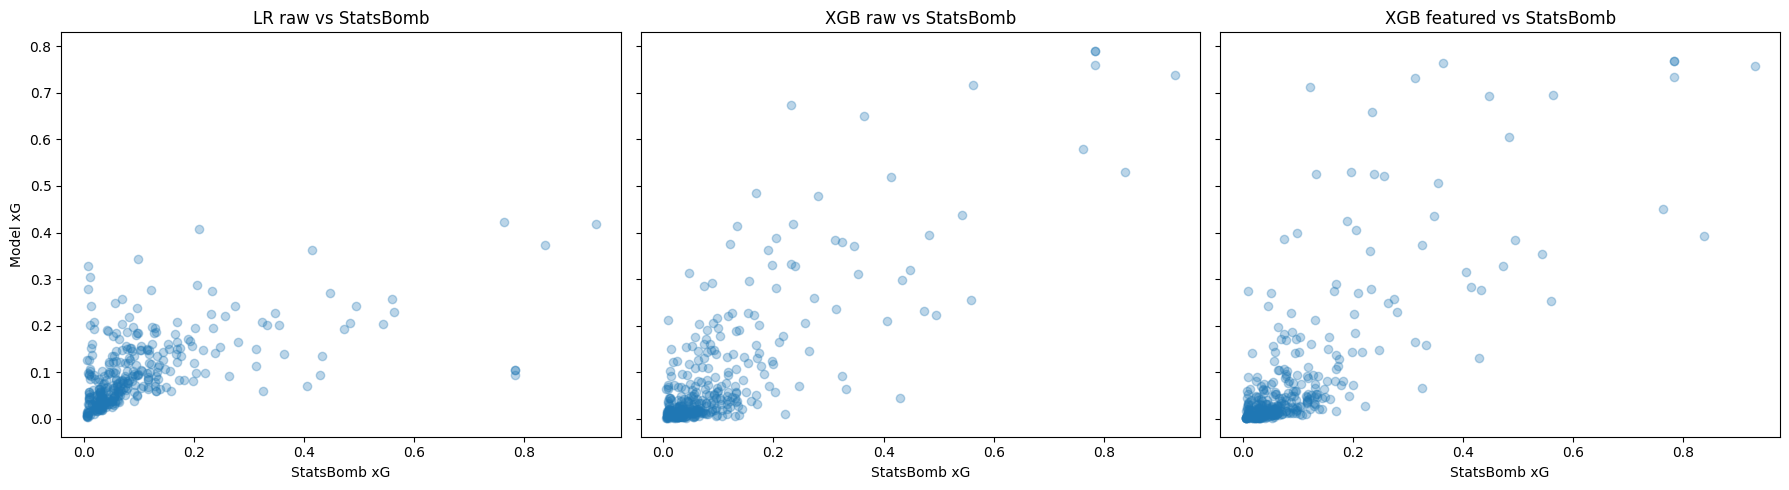

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

axes[0].scatter(comparison_df["shot_statsbomb_xg"], comparison_df["lr_raw"], alpha=0.3)
axes[0].set_title("LR raw vs StatsBomb")
axes[0].set_xlabel("StatsBomb xG")
axes[0].set_ylabel("Model xG")

axes[1].scatter(comparison_df["shot_statsbomb_xg"], comparison_df["xgb_raw"], alpha=0.3)
axes[1].set_title("XGB raw vs StatsBomb")
axes[1].set_xlabel("StatsBomb xG")

axes[2].scatter(comparison_df["shot_statsbomb_xg"], comparison_df["xgb_featured"], alpha=0.3)
axes[2].set_title("XGB featured vs StatsBomb")
axes[2].set_xlabel("StatsBomb xG")

plt.tight_layout()
plt.show()


## (Optional) Save models to disk


In [54]:
# import joblib
# joblib.dump(lr_raw, "lr_raw_wc2018.pkl")
# joblib.dump(xgb_raw, "xgb_raw_wc2018.pkl")
# joblib.dump(lr_featured, "lr_featured_wc2018.pkl")
# joblib.dump(xgb_featured, "xgb_featured_wc2018.pkl")
# joblib.dump(lr_scaled, "lr_scaled_wc2018.pkl")
# joblib.dump(scaler, "scaler_wc2018.pkl")
# print("Saved models and scaler to disk.")


# Models evaluation on Euro 2020

In [55]:
# Logistic Regression (raw)
lr_raw_pred_eu = lr_raw.predict_proba(X_raw_eu)[:, 1]

# XGBoost (raw)
xgb_raw_pred_eu = xgb_raw.predict_proba(X_raw_eu)[:, 1]

# Logistic Regression (featured)
lr_feat_pred_eu = lr_featured.predict_proba(X_feat_eu)[:, 1]

# XGBoost (featured)
xgb_feat_pred_eu = xgb_featured.predict_proba(X_feat_eu)[:, 1]

# LR Scaled
X_eu_scaled = scaler.transform(X_feat_eu)
lr_scaled_pred_eu = lr_scaled.predict_proba(X_eu_scaled)[:, 1]


# BUILD COMPARISON TABLE

eu_eval = pd.DataFrame({
    "statsbomb_xg": shots_eu["shot_statsbomb_xg"],
    "is_goal": y_eu,
    "lr_raw": lr_raw_pred_eu,
    "xgb_raw": xgb_raw_pred_eu,
    "lr_featured": lr_feat_pred_eu,
    "xgb_featured": xgb_feat_pred_eu,
    "lr_scaled": lr_scaled_pred_eu
})

display(eu_eval.head())


# TOTAL GOALS & XG SUMS

print("=== EURO 2020 TOTALS ===")
print(f"Actual Goals: {eu_eval['is_goal'].sum():.2f}")
print(f"StatsBomb xG: {eu_eval['statsbomb_xg'].sum():.2f}")
print(f"LR raw xG: {eu_eval['lr_raw'].sum():.2f}")
print(f"XGB raw xG: {eu_eval['xgb_raw'].sum():.2f}")
print(f"LR featured xG: {eu_eval['lr_featured'].sum():.2f}")
print(f"XGB featured xG: {eu_eval['xgb_featured'].sum():.2f}")
print(f"LR scaled xG: {eu_eval['lr_scaled'].sum():.2f}")


# AUC + BRIER SCORES

dataset = "EURO_2020"
stage = "pre"

all_auc[stage][dataset] = {}
all_brier[stage][dataset] = {}



all_xg[stage][dataset] = {
    "goals": eu_eval["is_goal"].sum(),
    "sb_xg": eu_eval["statsbomb_xg"].sum(),
    "lr_raw": eu_eval["lr_raw"].sum(),
    "xgb_raw": eu_eval["xgb_raw"].sum(),
    "lr_featured": eu_eval["lr_featured"].sum(),
    "xgb_featured": eu_eval["xgb_featured"].sum(),
    "lr_scaled": eu_eval["lr_scaled"].sum(),
}
print("\n=== EURO 2020 AUC & Brier ===")

models = ["lr_raw", "xgb_raw", "lr_featured", "xgb_featured", "lr_scaled"]

for m in models:
    auc = roc_auc_score(eu_eval["is_goal"], eu_eval[m])
    brier = brier_score_loss(eu_eval["is_goal"], eu_eval[m])
    print(f"{m:15} AUC: {auc:.4f}   Brier: {brier:.4f}")
    all_auc[stage][dataset][m] = auc
    all_brier[stage][dataset][m] = brier
    

,statsbomb_xg,is_goal,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
0,0.030169,0,0.019389,0.008783,0.025583,0.032158,0.025986
1,0.021315,0,0.049139,0.009144,0.029515,0.007104,0.032338
2,0.047888,0,0.086222,0.010739,0.059623,0.003650,0.064149
3,0.100356,0,0.146564,0.156174,0.263471,0.147764,0.256568
4,0.008758,0,0.050915,0.066121,0.019041,0.116477,0.023986


=== EURO 2020 TOTALS ===
Actual Goals: 131.00
StatsBomb xG: 133.40
LR raw xG: 123.71
XGB raw xG: 119.47
LR featured xG: 123.46
XGB featured xG: 112.76
LR scaled xG: 122.58

=== EURO 2020 AUC & Brier ===
lr_raw          AUC: 0.7033   Brier: 0.0881
xgb_raw         AUC: 0.7362   Brier: 0.0894
lr_featured     AUC: 0.7650   Brier: 0.0824
xgb_featured    AUC: 0.7368   Brier: 0.0905
lr_scaled       AUC: 0.7615   Brier: 0.0826


In [56]:
# PREDICTIONS FOR WC 2022 

# Logistic Regression (raw)
lr_raw_pred_wc_22 = lr_raw.predict_proba(X_raw_wc_22)[:, 1]

# XGBoost (raw)
xgb_raw_pred_wc_22 = xgb_raw.predict_proba(X_raw_wc_22)[:, 1]

# Logistic Regression (featured)
lr_feat_pred_wc_22 = lr_featured.predict_proba(X_feat_wc_22)[:, 1]

# XGBoost (featured)
xgb_feat_pred_wc_22 = xgb_featured.predict_proba(X_feat_wc_22)[:, 1]

# LR Scaled
X_wc_22_scaled = scaler.transform(X_feat_wc_22)
lr_scaled_pred_wc_22 = lr_scaled.predict_proba(X_wc_22_scaled)[:, 1]


# BUILD COMPARISON TABLE

wc_22_eval = pd.DataFrame({
    "statsbomb_xg": shots_WC_22["shot_statsbomb_xg"],
    "is_goal": y_wc_22,
    "lr_raw": lr_raw_pred_wc_22,
    "xgb_raw": xgb_raw_pred_wc_22,
    "lr_featured": lr_feat_pred_wc_22,
    "xgb_featured": xgb_feat_pred_wc_22,
    "lr_scaled": lr_scaled_pred_wc_22
})

display(wc_22_eval.head())

# save results in dictionary

dataset = "WC_2022"
stage = "pre"


all_auc[stage][dataset] = {}
all_brier[stage][dataset] = {}

# TOTAL GOALS & XG SUMS


print("=== WORLD CUP 2022 TOTALS ===")
print(f"Actual Goals: {wc_22_eval['is_goal'].sum():.2f}")
print(f"StatsBomb xG: {wc_22_eval['statsbomb_xg'].sum():.2f}")
print(f"LR raw xG: {wc_22_eval['lr_raw'].sum():.2f}")
print(f"XGB raw xG: {wc_22_eval['xgb_raw'].sum():.2f}")
print(f"LR featured xG: {wc_22_eval['lr_featured'].sum():.2f}")
print(f"XGB featured xG: {wc_22_eval['xgb_featured'].sum():.2f}")
print(f"LR scaled xG: {wc_22_eval['lr_scaled'].sum():.2f}")

all_xg[stage][dataset] = {
    "goals": wc_22_eval["is_goal"].sum(),
    "sb_xg": wc_22_eval["statsbomb_xg"].sum(),
    "lr_raw": wc_22_eval["lr_raw"].sum(),
    "xgb_raw": wc_22_eval["xgb_raw"].sum(),
    "lr_featured": wc_22_eval["lr_featured"].sum(),
    "xgb_featured": wc_22_eval["xgb_featured"].sum(),
    "lr_scaled": wc_22_eval["lr_scaled"].sum(),
}
# AUC + BRIER SCORES


print("\n=== WORLD CUP 2022 AUC & Brier ===")

models = ["lr_raw", "xgb_raw", "lr_featured", "xgb_featured", "lr_scaled"]

for m in models:
    auc = roc_auc_score(wc_22_eval["is_goal"], wc_22_eval[m])
    brier = brier_score_loss(wc_22_eval["is_goal"], wc_22_eval[m])
    print(f"{m:15} AUC: {auc:.4f}   Brier: {brier:.4f}")
    all_auc[stage][dataset][m] = auc
    all_brier[stage][dataset][m] = brier


,statsbomb_xg,is_goal,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
0,0.036566,0,0.050310,0.030390,0.052793,0.008314,0.051514
1,0.353289,0,0.249420,0.593617,0.358699,0.289725,0.359184
2,0.069527,0,0.109397,0.012076,0.132185,0.019914,0.121523
3,0.081609,0,0.145052,0.107629,0.222992,0.046209,0.217838
4,0.030002,0,0.039605,0.006563,0.035117,0.004794,0.036971


=== WORLD CUP 2022 TOTALS ===
Actual Goals: 169.00
StatsBomb xG: 155.90
LR raw xG: 149.08
XGB raw xG: 145.32
LR featured xG: 147.74
XGB featured xG: 133.15
LR scaled xG: 147.19

=== WORLD CUP 2022 AUC & Brier ===
lr_raw          AUC: 0.7192   Brier: 0.0963
xgb_raw         AUC: 0.7590   Brier: 0.0896
lr_featured     AUC: 0.7814   Brier: 0.0895
xgb_featured    AUC: 0.7559   Brier: 0.0915
lr_scaled       AUC: 0.7795   Brier: 0.0900


# Re-trainig using hot encoding for categorical columns

In [57]:
# LOAD ENCODED DATASETS

shots_18 = pd.read_csv("shots_featured_enc.csv")
shots_eu = pd.read_csv("shots_euro_enc.csv")
shots_22 = pd.read_csv("shots_WC_22_enc.csv")

print("Loaded:", shots_18.shape, shots_eu.shape, shots_22.shape)

# Drop columns we never use for training
drop_cols = ["is_goal", "shot_statsbomb_xg"]

# ALL features:
all_cols = [c for c in shots_18.columns if c not in drop_cols]

# Geometry columns
geom_cols = ["distance", "angle"]

# Raw = all except geometry
raw_cols = [c for c in all_cols if c not in geom_cols]

# Featured = raw + geometry
feat_cols = raw_cols + geom_cols

# WC18 (train source)
X_raw_18  = shots_18[raw_cols].values
X_feat_18 = shots_18[feat_cols].values
y_18      = shots_18["is_goal"].astype(int).values

# EURO
X_raw_eu  = shots_eu[raw_cols].values
X_feat_eu = shots_eu[feat_cols].values
y_eu      = shots_eu["is_goal"].astype(int).values

# WC22
X_raw_22  = shots_22[raw_cols].values
X_feat_22 = shots_22[feat_cols].values
y_22      = shots_22["is_goal"].astype(int).values

# TRAIN/TEST SPLIT (WC18)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw_18, y_18, test_size=0.2, random_state=42, stratify=y_18
)

X_train_feat = shots_18.loc[X_train_raw.index if hasattr(X_train_raw, "index") else None, feat_cols].values \
    if False else shots_18[feat_cols].values

# Actually easier:
X_train_feat, X_test_feat = train_test_split(
    X_feat_18, test_size=0.2, random_state=42, stratify=y_18
)


# Logistic Regression (raw)
lr_raw = LogisticRegression(max_iter=2000)

# XGBoost (raw)
xgb_raw = XGBClassifier(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss"
)

# Logistic Regression (featured)
lr_featured = LogisticRegression(max_iter=2000)

# XGBoost (featured)
xgb_featured = XGBClassifier(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss"
)

# LR scaled (featured)
scaler = StandardScaler(with_mean=False)
X_train_feat_scaled = scaler.fit_transform(X_train_feat)
lr_scaled = LogisticRegression(max_iter=2000)



# TRAIN MODELS

print("Training LR_raw...")
lr_raw.fit(X_train_raw, y_train)

print("Training XGB_raw...")
xgb_raw.fit(X_train_raw, y_train)

print("Training LR_featured...")
lr_featured.fit(X_train_feat, y_train)

print("Training XGB_featured...")
xgb_featured.fit(X_train_feat, y_train)

print("Training LR_scaled...")
lr_scaled.fit(X_train_feat_scaled, y_train)




Loaded: (1667, 21) (1251, 21) (1451, 21)
Training LR_raw...
Training XGB_raw...
Training LR_featured...
Training XGB_featured...
Training LR_scaled...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [58]:
print("=== WC18 test split (RAW, OHE) ===")

lr_raw_pred_18 = lr_raw.predict_proba(X_test_raw)[:, 1]
xgb_raw_pred_18 = xgb_raw.predict_proba(X_test_raw)[:, 1]

auc_lr_raw_18 = roc_auc_score(y_test, lr_raw_pred_18)
auc_xgb_raw_18 = roc_auc_score(y_test, xgb_raw_pred_18)

brier_lr_raw_18 = brier_score_loss(y_test, lr_raw_pred_18)
brier_xgb_raw_18 = brier_score_loss(y_test, xgb_raw_pred_18)

print(f"LR_raw AUC: {auc_lr_raw_18:.4f}  Brier: {brier_lr_raw_18:.4f}")
print(f"XGB_raw AUC: {auc_xgb_raw_18:.4f}  Brier: {brier_xgb_raw_18:.4f}")

# FEATURED
print("\n=== WC18 test split (FEATURED, OHE) ===")

lr_feat_pred_18 = lr_featured.predict_proba(X_test_feat)[:, 1]
xgb_feat_pred_18 = xgb_featured.predict_proba(X_test_feat)[:, 1]
lr_scaled_pred_18 = lr_scaled.predict_proba(scaler.transform(X_test_feat))[:, 1]

auc_lr_feat_18 = roc_auc_score(y_test, lr_feat_pred_18)
auc_xgb_feat_18 = roc_auc_score(y_test, xgb_feat_pred_18)
auc_lr_scaled_18 = roc_auc_score(y_test, lr_scaled_pred_18)

brier_lr_feat_18 = brier_score_loss(y_test, lr_feat_pred_18)
brier_xgb_feat_18 = brier_score_loss(y_test, xgb_feat_pred_18)
brier_lr_scaled_18 = brier_score_loss(y_test, lr_scaled_pred_18)

print(f"LR_featured AUC: {auc_lr_feat_18:.4f}   Brier: {brier_lr_feat_18:.4f}")
print(f"XGB_featured AUC: {auc_xgb_feat_18:.4f}   Brier: {brier_xgb_feat_18:.4f}")
print(f"LR_scaled AUC:    {auc_lr_scaled_18:.4f}   Brier: {brier_lr_scaled_18:.4f}")

# STORE DICTIONARY
all_auc["ohe"]["WC18_test"] = {
    "lr_raw": auc_lr_raw_18,
    "xgb_raw": auc_xgb_raw_18,
    "lr_featured": auc_lr_feat_18,
    "xgb_featured": auc_xgb_feat_18,
    "lr_scaled": auc_lr_scaled_18,
}

all_brier["ohe"]["WC18_test"] = {
    "lr_raw": brier_lr_raw_18,
    "xgb_raw": brier_xgb_raw_18,
    "lr_featured": brier_lr_feat_18,
    "xgb_featured": brier_xgb_feat_18,
    "lr_scaled": brier_lr_scaled_18,
}


=== WC18 test split (RAW, OHE) ===
LR_raw AUC: 0.7340  Brier: 0.0720
XGB_raw AUC: 0.7116  Brier: 0.0736

=== WC18 test split (FEATURED, OHE) ===
LR_featured AUC: 0.7552   Brier: 0.0698
XGB_featured AUC: 0.7008   Brier: 0.0749
LR_scaled AUC:    0.7501   Brier: 0.0696


In [59]:
print("=== EURO 2020 (RAW, OHE) ===")

lr_raw_pred_eu = lr_raw.predict_proba(X_raw_eu)[:, 1]
xgb_raw_pred_eu = xgb_raw.predict_proba(X_raw_eu)[:, 1]

auc_lr_raw_eu = roc_auc_score(y_eu, lr_raw_pred_eu)
auc_xgb_raw_eu = roc_auc_score(y_eu, xgb_raw_pred_eu)

brier_lr_raw_eu = brier_score_loss(y_eu, lr_raw_pred_eu)
brier_xgb_raw_eu = brier_score_loss(y_eu, xgb_raw_pred_eu)

print(f"LR_raw AUC: {auc_lr_raw_eu:.4f}  Brier: {brier_lr_raw_eu:.4f}")
print(f"XGB_raw AUC: {auc_xgb_raw_eu:.4f}  Brier: {brier_xgb_raw_eu:.4f}")

print("\nTotals:")
print("Goals:", shots_eu["is_goal"].sum())
print("LR_raw:", lr_raw_pred_eu.sum())
print("XGB_raw:", xgb_raw_pred_eu.sum())
print("SB_xG:", shots_eu["shot_statsbomb_xg"].sum())

# FEATURED
print("\n=== EURO 2020 (FEATURED, OHE) ===")

lr_feat_pred_eu = lr_featured.predict_proba(X_feat_eu)[:, 1]
xgb_feat_pred_eu = xgb_featured.predict_proba(X_feat_eu)[:, 1]
lr_scaled_pred_eu = lr_scaled.predict_proba(scaler.transform(X_feat_eu))[:, 1]

auc_lr_feat_eu = roc_auc_score(y_eu, lr_feat_pred_eu)
auc_xgb_feat_eu = roc_auc_score(y_eu, xgb_feat_pred_eu)
auc_lr_scaled_eu = roc_auc_score(y_eu, lr_scaled_pred_eu)

brier_lr_feat_eu = brier_score_loss(y_eu, lr_feat_pred_eu)
brier_xgb_feat_eu = brier_score_loss(y_eu, xgb_feat_pred_eu)
brier_lr_scaled_eu = brier_score_loss(y_eu, lr_scaled_pred_eu)

print(f"LR_featured AUC: {auc_lr_feat_eu:.4f}   Brier: {brier_lr_feat_eu:.4f}")
print(f"XGB_featured AUC: {auc_xgb_feat_eu:.4f}   Brier: {brier_xgb_feat_eu:.4f}")
print(f"LR_scaled AUC:    {auc_lr_scaled_eu:.4f}   Brier: {brier_lr_scaled_eu:.4f}")

# STORE
all_auc["ohe"]["EURO_2020"] = {
    "lr_raw": auc_lr_raw_eu,
    "xgb_raw": auc_xgb_raw_eu,
    "lr_featured": auc_lr_feat_eu,
    "xgb_featured": auc_xgb_feat_eu,
    "lr_scaled": auc_lr_scaled_eu,
}

all_brier["ohe"]["EURO_2020"] = {
    "lr_raw": brier_lr_raw_eu,
    "xgb_raw": brier_xgb_raw_eu,
    "lr_featured": brier_lr_feat_eu,
    "xgb_featured": brier_xgb_feat_eu,
    "lr_scaled": brier_lr_scaled_eu,
}

all_xg["ohe"]["EURO_2020"] = {
    "goals": shots_eu["is_goal"].sum(),
    "sb_xg": shots_eu["shot_statsbomb_xg"].sum(),
    "lr_raw": lr_raw_pred_eu.sum(),
    "xgb_raw": xgb_raw_pred_eu.sum(),
    "lr_featured": lr_feat_pred_eu.sum(),
    "xgb_featured": xgb_feat_pred_eu.sum(),
    "lr_scaled": lr_scaled_pred_eu.sum(),
}


=== EURO 2020 (RAW, OHE) ===
LR_raw AUC: 0.7314  Brier: 0.0855
XGB_raw AUC: 0.7557  Brier: 0.0854

Totals:
Goals: 131
LR_raw: 117.63216346654097
XGB_raw: 109.57264
SB_xG: 133.39686355240002

=== EURO 2020 (FEATURED, OHE) ===
LR_featured AUC: 0.7776   Brier: 0.0807
XGB_featured AUC: 0.7552   Brier: 0.0867
LR_scaled AUC:    0.7734   Brier: 0.0813


In [60]:
print("=== WORLD CUP 2022 (RAW, OHE) ===")

lr_raw_pred_wc22 = lr_raw.predict_proba(X_raw_22)[:, 1]
xgb_raw_pred_wc22 = xgb_raw.predict_proba(X_raw_22)[:, 1]

auc_lr_raw_wc22 = roc_auc_score(y_22, lr_raw_pred_wc22)
auc_xgb_raw_wc22 = roc_auc_score(y_22, xgb_raw_pred_wc22)

brier_lr_raw_wc22 = brier_score_loss(y_22, lr_raw_pred_wc22)
brier_xgb_raw_wc22 = brier_score_loss(y_22, xgb_raw_pred_wc22)

print(f"LR_raw AUC: {auc_lr_raw_wc22:.4f}  Brier: {brier_lr_raw_wc22:.4f}")
print(f"XGB_raw AUC: {auc_xgb_raw_wc22:.4f}  Brier: {brier_xgb_raw_wc22:.4f}")

print("\nTotals:")
print("Goals:", shots_22["is_goal"].sum())
print("LR_raw:", lr_raw_pred_wc22.sum())
print("XGB_raw:", xgb_raw_pred_wc22.sum())
print("SB_xG:", shots_22["shot_statsbomb_xg"].sum())

# FEATURED
print("\n=== WORLD CUP 2022 (FEATURED, OHE) ===")

lr_feat_pred_wc22 = lr_featured.predict_proba(X_feat_22)[:, 1]
xgb_feat_pred_wc22 = xgb_featured.predict_proba(X_feat_22)[:, 1]
lr_scaled_pred_wc22 = lr_scaled.predict_proba(scaler.transform(X_feat_22))[:, 1]

auc_lr_feat_wc22 = roc_auc_score(y_22, lr_feat_pred_wc22)
auc_xgb_feat_wc22 = roc_auc_score(y_22, xgb_feat_pred_wc22)
auc_lr_scaled_wc22 = roc_auc_score(y_22, lr_scaled_pred_wc22)

brier_lr_feat_wc22 = brier_score_loss(y_22, lr_feat_pred_wc22)
brier_xgb_feat_wc22 = brier_score_loss(y_22, xgb_feat_pred_wc22)
brier_lr_scaled_wc22 = brier_score_loss(y_22, lr_scaled_pred_wc22)

print(f"LR_featured AUC: {auc_lr_feat_wc22:.4f}   Brier: {brier_lr_feat_wc22:.4f}")
print(f"XGB_featured AUC: {auc_xgb_feat_wc22:.4f}   Brier: {brier_xgb_feat_wc22:.4f}")
print(f"LR_scaled AUC:    {auc_lr_scaled_wc22:.4f}   Brier: {brier_lr_scaled_wc22:.4f}")

# STORE
all_auc["ohe"]["WC_2022"] = {
    "lr_raw": auc_lr_raw_wc22,
    "xgb_raw": auc_xgb_raw_wc22,
    "lr_featured": auc_lr_feat_wc22,
    "xgb_featured": auc_xgb_feat_wc22,
    "lr_scaled": auc_lr_scaled_wc22,
}

all_brier["ohe"]["WC_2022"] = {
    "lr_raw": brier_lr_raw_wc22,
    "xgb_raw": brier_xgb_raw_wc22,
    "lr_featured": brier_lr_feat_wc22,
    "xgb_featured": brier_xgb_feat_wc22,
    "lr_scaled": brier_lr_scaled_wc22,
}

all_xg["ohe"]["WC_2022"] = {
    "goals": shots_22["is_goal"].sum(),
    "sb_xg": shots_22["shot_statsbomb_xg"].sum(),
    "lr_raw": lr_raw_pred_wc22.sum(),
    "xgb_raw": xgb_raw_pred_wc22.sum(),
    "lr_featured": lr_feat_pred_wc22.sum(),
    "xgb_featured": xgb_feat_pred_wc22.sum(),
    "lr_scaled": lr_scaled_pred_wc22.sum(),
}


=== WORLD CUP 2022 (RAW, OHE) ===
LR_raw AUC: 0.7662  Brier: 0.0891
XGB_raw AUC: 0.7689  Brier: 0.0899

Totals:
Goals: 169
LR_raw: 141.86037113694596
XGB_raw: 139.92374
SB_xG: 155.8981819302

=== WORLD CUP 2022 (FEATURED, OHE) ===
LR_featured AUC: 0.8071   Brier: 0.0847
XGB_featured AUC: 0.7760   Brier: 0.0896
LR_scaled AUC:    0.8060   Brier: 0.0852


In [61]:
# Build aggregated metrics


results_auc = []
results_brier = []
results_xg = []

datasets = {
    "WC18_test": (X_test_raw, X_test_feat, y_test, None),
    "EURO_2020": (X_raw_eu, X_feat_eu, y_eu, shots_eu),
    "WC_2022": (X_raw_22, X_feat_22, y_22, shots_22),
}

for name, (X_raw, X_feat, y, df) in datasets.items():
    
    # RAW models
    lr_raw_pred  = lr_raw.predict_proba(X_raw)[:,1]
    xgb_raw_pred = xgb_raw.predict_proba(X_raw)[:,1]
    
    # FEATURED models
    lr_feat_pred = lr_featured.predict_proba(X_feat)[:,1]
    xgb_feat_pred = xgb_featured.predict_proba(X_feat)[:,1]
    
    # SCALED
    lr_scaled_pred = lr_scaled.predict_proba(
        scaler.transform(X_feat))[:,1]

    # AUC & Brier
    results_auc.append([name, 
                        roc_auc_score(y, lr_raw_pred),
                        roc_auc_score(y, xgb_raw_pred),
                        roc_auc_score(y, lr_feat_pred),
                        roc_auc_score(y, xgb_feat_pred),
                        roc_auc_score(y, lr_scaled_pred)
                       ])
    
    results_brier.append([name, 
                          brier_score_loss(y, lr_raw_pred),
                          brier_score_loss(y, xgb_raw_pred),
                          brier_score_loss(y, lr_feat_pred),
                          brier_score_loss(y, xgb_feat_pred),
                          brier_score_loss(y, lr_scaled_pred)
                         ])
    
    # xG totals
    if df is not None:
        results_xg.append([
            name,
            df["is_goal"].sum(),
            df["shot_statsbomb_xg"].sum(),
            lr_raw_pred.sum(),
            xgb_raw_pred.sum(),
            lr_feat_pred.sum(),
            xgb_feat_pred.sum(),
            lr_scaled_pred.sum()
        ])

# Convert to dataframes
auc_table = pd.DataFrame(results_auc,
                         columns=["Dataset","LR_raw","XGB_raw","LR_feat","XGB_feat","LR_scaled"])

brier_table = pd.DataFrame(results_brier,
                           columns=["Dataset","LR_raw","XGB_raw","LR_feat","XGB_feat","LR_scaled"])

xg_table = pd.DataFrame(results_xg,
                        columns=["Dataset","Goals","SB_xG","LR_raw","XGB_raw","LR_feat","XGB_feat","LR_scaled"])

display(auc_table)
display(brier_table)
display(xg_table)


,Dataset,LR_raw,XGB_raw,LR_feat,XGB_feat,LR_scaled
0,WC18_test,0.733951,0.711594,0.755243,0.700841,0.750133
1,EURO_2020,0.731397,0.755681,0.777597,0.755183,0.773361
2,WC_2022,0.766249,0.768862,0.807111,0.776023,0.805971


,Dataset,LR_raw,XGB_raw,LR_feat,XGB_feat,LR_scaled
0,WC18_test,0.072020,0.073633,0.069772,0.074917,0.069608
1,EURO_2020,0.085546,0.085387,0.080689,0.086694,0.081291
2,WC_2022,0.089100,0.089898,0.084655,0.089592,0.085159


,Dataset,Goals,SB_xG,LR_raw,XGB_raw,LR_feat,XGB_feat,LR_scaled
0,EURO_2020,131,133.396864,117.632163,109.572639,117.520867,107.400925,117.093782
1,WC_2022,169,155.898182,141.860371,139.923737,140.219375,131.751068,140.435568


In [64]:


# LOAD ENCODED + FF DATASETS


shots_wc18_ff_enc  = pd.read_csv("ff_preprocessed_encoded/shots_wc18_ff_enc.csv")
shots_euro_ff_enc  = pd.read_csv("ff_preprocessed_encoded/shots_euro_ff_enc.csv")
shots_wc22_ff_enc  = pd.read_csv("ff_preprocessed_encoded/shots_wc22_ff_enc.csv")

print("Shapes (WC18, EURO, WC22):",
      shots_wc18_ff_enc.shape,
      shots_euro_ff_enc.shape,
      shots_wc22_ff_enc.shape)




# Columns we never train on
drop_cols = ["is_goal", "shot_statsbomb_xg", "shot_freeze_frame"]

all_feature_cols = [c for c in shots_wc18_ff_enc.columns if c not in drop_cols]

# Geometry
geom_cols = ["distance", "angle"]

# Freeze-frame numeric features
ff_cols = ["defenders_between", "min_defender_dist", "defenders_in_cone"]

# RAW = all features EXCEPT distance, angle, and FF features
raw_cols = [c for c in all_feature_cols if c not in geom_cols + ff_cols]

# FEATURED = RAW + distance + angle + FF
feat_cols = raw_cols + geom_cols + ff_cols

print("Number of raw features:     ", len(raw_cols))
print("Number of featured + FF:   ", len(feat_cols))


# BUILD MATRICES


# WC18 (train source)
X_raw_18_df  = shots_wc18_ff_enc[raw_cols]
X_feat_18_df = shots_wc18_ff_enc[feat_cols]
y_18         = shots_wc18_ff_enc["is_goal"].astype(int).values

# EURO
X_raw_eu  = shots_euro_ff_enc[raw_cols].values
X_feat_eu = shots_euro_ff_enc[feat_cols].values
y_eu      = shots_euro_ff_enc["is_goal"].astype(int).values

# WC22
X_raw_22  = shots_wc22_ff_enc[raw_cols].values
X_feat_22 = shots_wc22_ff_enc[feat_cols].values
y_22      = shots_wc22_ff_enc["is_goal"].astype(int).values


# TRAIN/TEST SPLIT ON WC18


# Split using FEATURED matrix, then align RAW using indices
X_train_feat_df, X_test_feat_df, y_train, y_test = train_test_split(
    X_feat_18_df, y_18, test_size=0.2, random_state=42, stratify=y_18
)

X_train_raw_df = X_raw_18_df.loc[X_train_feat_df.index]
X_test_raw_df  = X_raw_18_df.loc[X_test_feat_df.index]

# Convert to numpy
X_train_raw  = X_train_raw_df.values
X_test_raw   = X_test_raw_df.values
X_train_feat = X_train_feat_df.values
X_test_feat  = X_test_feat_df.values

print("WC18 train/test shapes (RAW):   ", X_train_raw.shape, X_test_raw.shape)
print("WC18 train/test shapes (FEAT):  ", X_train_feat.shape, X_test_feat.shape)


# INITIALIZE MODELS


# Logistic Regression (raw)
lr_raw = LogisticRegression(max_iter=2000)

# XGBoost (raw)
xgb_raw = XGBClassifier(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss"
)

# Logistic Regression (featured + FF)
lr_featured = LogisticRegression(max_iter=2000)

# XGBoost (featured + FF)
xgb_featured = XGBClassifier(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss"
)

# LR scaled (featured + FF)
scaler = StandardScaler(with_mean=False)
X_train_feat_scaled = scaler.fit_transform(X_train_feat)
lr_scaled = LogisticRegression(max_iter=2000)


# TRAIN MODELS

print("Training LR_raw...")
lr_raw.fit(X_train_raw, y_train)

print("Training XGB_raw...")
xgb_raw.fit(X_train_raw, y_train)

print("Training LR_featured + FF...")
lr_featured.fit(X_train_feat, y_train)

print("Training XGB_featured + FF...")
xgb_featured.fit(X_train_feat, y_train)

print("Training LR_scaled + FF...")
lr_scaled.fit(X_train_feat_scaled, y_train)



Shapes (WC18, EURO, WC22): (1667, 29) (1251, 29) (1453, 29)
Number of raw features:      21
Number of featured + FF:    26
WC18 train/test shapes (RAW):    (1333, 21) (334, 21)
WC18 train/test shapes (FEAT):   (1333, 26) (334, 26)
Training LR_raw...
Training XGB_raw...
Training LR_featured + FF...
Training XGB_featured + FF...
Training LR_scaled + FF...


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [65]:
dataset = "WC18_test"
stage = "ff"

all_auc[stage][dataset] = {}
all_brier[stage][dataset] = {}
# WC18 has no totals table because test split has no SB xG
# but we still save predictions for consistency

print("=== WC18 test split (RAW, FF+OHE) ===")

lr_raw_pred_18 = lr_raw.predict_proba(X_test_raw)[:, 1]
xgb_raw_pred_18 = xgb_raw.predict_proba(X_test_raw)[:, 1]

# AUC / Brier
auc_lr_raw_18 = roc_auc_score(y_test, lr_raw_pred_18)
auc_xgb_raw_18 = roc_auc_score(y_test, xgb_raw_pred_18)

brier_lr_raw_18 = brier_score_loss(y_test, lr_raw_pred_18)
brier_xgb_raw_18 = brier_score_loss(y_test, xgb_raw_pred_18)

print(f"LR_raw     AUC={auc_lr_raw_18:.4f}  Brier={brier_lr_raw_18:.4f}")
print(f"XGB_raw    AUC={auc_xgb_raw_18:.4f}  Brier={brier_xgb_raw_18:.4f}")

# Save
all_auc[stage][dataset]["lr_raw"] = auc_lr_raw_18
all_auc[stage][dataset]["xgb_raw"] = auc_xgb_raw_18

all_brier[stage][dataset]["lr_raw"] = brier_lr_raw_18
all_brier[stage][dataset]["xgb_raw"] = brier_xgb_raw_18


# FEATURED + FF
print("\n=== WC18 test split (FEATURED, FF+OHE) ===")

lr_feat_pred_18 = lr_featured.predict_proba(X_test_feat)[:, 1]
xgb_feat_pred_18 = xgb_featured.predict_proba(X_test_feat)[:, 1]
lr_scaled_pred_18 = lr_scaled.predict_proba(scaler.transform(X_test_feat))[:, 1]

# AUC / Brier
auc_lr_feat_18 = roc_auc_score(y_test, lr_feat_pred_18)
auc_xgb_feat_18 = roc_auc_score(y_test, xgb_feat_pred_18)
auc_lr_scaled_18 = roc_auc_score(y_test, lr_scaled_pred_18)

brier_lr_feat_18 = brier_score_loss(y_test, lr_feat_pred_18)
brier_xgb_feat_18 = brier_score_loss(y_test, xgb_feat_pred_18)
brier_lr_scaled_18 = brier_score_loss(y_test, lr_scaled_pred_18)

print(f"LR_featured AUC={auc_lr_feat_18:.4f}  Brier={brier_lr_feat_18:.4f}")
print(f"XGB_featured AUC={auc_xgb_feat_18:.4f}  Brier={brier_xgb_feat_18:.4f}")
print(f"LR_scaled    AUC={auc_lr_scaled_18:.4f}  Brier={brier_lr_scaled_18:.4f}")

# Save
all_auc[stage][dataset]["lr_featured"] = auc_lr_feat_18
all_auc[stage][dataset]["xgb_featured"] = auc_xgb_feat_18
all_auc[stage][dataset]["lr_scaled"] = auc_lr_scaled_18

all_brier[stage][dataset]["lr_featured"] = brier_lr_feat_18
all_brier[stage][dataset]["xgb_featured"] = brier_xgb_feat_18
all_brier[stage][dataset]["lr_scaled"] = brier_lr_scaled_18


=== WC18 test split (RAW, FF+OHE) ===
LR_raw     AUC=0.7338  Brier=0.0719
XGB_raw    AUC=0.7164  Brier=0.0742

=== WC18 test split (FEATURED, FF+OHE) ===
LR_featured AUC=0.7585  Brier=0.0666
XGB_featured AUC=0.7163  Brier=0.0725
LR_scaled    AUC=0.7550  Brier=0.0670


In [66]:
dataset = "EURO_2020"
stage = "ff"

all_auc[stage][dataset] = {}
all_brier[stage][dataset] = {}
all_xg[stage][dataset] = {}

print("=== EURO 2020 (RAW, FF+OHE) ===")

lr_raw_pred_eu = lr_raw.predict_proba(X_raw_eu)[:, 1]
xgb_raw_pred_eu = xgb_raw.predict_proba(X_raw_eu)[:, 1]

auc_lr_raw_eu = roc_auc_score(y_eu, lr_raw_pred_eu)
auc_xgb_raw_eu = roc_auc_score(y_eu, xgb_raw_pred_eu)

brier_lr_raw_eu = brier_score_loss(y_eu, lr_raw_pred_eu)
brier_xgb_raw_eu = brier_score_loss(y_eu, xgb_raw_pred_eu)

print(f"LR_raw     AUC={auc_lr_raw_eu:.4f}  Brier={brier_lr_raw_eu:.4f}")
print(f"XGB_raw    AUC={auc_xgb_raw_eu:.4f}  Brier={brier_xgb_raw_eu:.4f}")

# Totals
print("\nTotals:")
print("Goals:", shots_euro_ff_enc["is_goal"].sum())
print("LR_raw:", lr_raw_pred_eu.sum())
print("XGB_raw:", xgb_raw_pred_eu.sum())
print("SB_xG:", shots_euro_ff_enc["shot_statsbomb_xg"].sum())

# Save
all_auc[stage][dataset]["lr_raw"] = auc_lr_raw_eu
all_auc[stage][dataset]["xgb_raw"] = auc_xgb_raw_eu
all_brier[stage][dataset]["lr_raw"] = brier_lr_raw_eu
all_brier[stage][dataset]["xgb_raw"] = brier_xgb_raw_eu

# xG
all_xg[stage][dataset] = {
    "goals": shots_euro_ff_enc["is_goal"].sum(),
    "sb_xg": shots_euro_ff_enc["shot_statsbomb_xg"].sum(),
    "lr_raw": lr_raw_pred_eu.sum(),
    "xgb_raw": xgb_raw_pred_eu.sum(),
}


print("\n=== EURO 2020 (FEATURED, FF+OHE) ===")

lr_feat_pred_eu = lr_featured.predict_proba(X_feat_eu)[:, 1]
xgb_feat_pred_eu = xgb_featured.predict_proba(X_feat_eu)[:, 1]
lr_scaled_pred_eu = lr_scaled.predict_proba(scaler.transform(X_feat_eu))[:, 1]

auc_lr_feat_eu = roc_auc_score(y_eu, lr_feat_pred_eu)
auc_xgb_feat_eu = roc_auc_score(y_eu, xgb_feat_pred_eu)
auc_lr_scaled_eu = roc_auc_score(y_eu, lr_scaled_pred_eu)

brier_lr_feat_eu = brier_score_loss(y_eu, lr_feat_pred_eu)
brier_xgb_feat_eu = brier_score_loss(y_eu, xgb_feat_pred_eu)
brier_lr_scaled_eu = brier_score_loss(y_eu, lr_scaled_pred_eu)

print(f"LR_featured AUC={auc_lr_feat_eu:.4f}  Brier={brier_lr_feat_eu:.4f}")
print(f"XGB_featured AUC={auc_xgb_feat_eu:.4f}  Brier={brier_xgb_feat_eu:.4f}")
print(f"LR_scaled    AUC={auc_lr_scaled_eu:.4f}  Brier={brier_lr_scaled_eu:.4f}")

# Save
all_auc[stage][dataset]["lr_featured"] = auc_lr_feat_eu
all_auc[stage][dataset]["xgb_featured"] = auc_xgb_feat_eu
all_auc[stage][dataset]["lr_scaled"] = auc_lr_scaled_eu

all_brier[stage][dataset]["lr_featured"] = brier_lr_feat_eu
all_brier[stage][dataset]["xgb_featured"] = brier_xgb_feat_eu
all_brier[stage][dataset]["lr_scaled"] = brier_lr_scaled_eu

# xG add
all_xg[stage][dataset].update({
    "lr_featured": lr_feat_pred_eu.sum(),
    "xgb_featured": xgb_feat_pred_eu.sum(),
    "lr_scaled": lr_scaled_pred_eu.sum(),
})


=== EURO 2020 (RAW, FF+OHE) ===
LR_raw     AUC=0.7314  Brier=0.0855
XGB_raw    AUC=0.7615  Brier=0.0852

Totals:
Goals: 131
LR_raw: 117.53302813306315
XGB_raw: 113.5312
SB_xG: 133.39686355240002

=== EURO 2020 (FEATURED, FF+OHE) ===
LR_featured AUC=0.7896  Brier=0.0778
XGB_featured AUC=0.7627  Brier=0.0834
LR_scaled    AUC=0.7841  Brier=0.0777


In [67]:
dataset = "WC_2022"
stage = "ff"

all_auc[stage][dataset] = {}
all_brier[stage][dataset] = {}
all_xg[stage][dataset] = {}

print("=== WC 2022 (RAW, FF+OHE) ===")

lr_raw_pred_wc22 = lr_raw.predict_proba(X_raw_22)[:, 1]
xgb_raw_pred_wc22 = xgb_raw.predict_proba(X_raw_22)[:, 1]

auc_lr_raw_wc22 = roc_auc_score(y_22, lr_raw_pred_wc22)
auc_xgb_raw_wc22 = roc_auc_score(y_22, xgb_raw_pred_wc22)

brier_lr_raw_wc22 = brier_score_loss(y_22, lr_raw_pred_wc22)
brier_xgb_raw_wc22 = brier_score_loss(y_22, xgb_raw_pred_wc22)

print(f"LR_raw     AUC={auc_lr_raw_wc22:.4f}  Brier={brier_lr_raw_wc22:.4f}")
print(f"XGB_raw    AUC={auc_xgb_raw_wc22:.4f}  Brier={brier_xgb_raw_wc22:.4f}")

print("\nTotals:")
print("Goals:", shots_wc22_ff_enc["is_goal"].sum())
print("LR_raw:", lr_raw_pred_wc22.sum())
print("XGB_raw:", xgb_raw_pred_wc22.sum())
print("SB_xG:", shots_wc22_ff_enc["shot_statsbomb_xg"].sum())

# Save raw
all_auc[stage][dataset]["lr_raw"] = auc_lr_raw_wc22
all_auc[stage][dataset]["xgb_raw"] = auc_xgb_raw_wc22
all_brier[stage][dataset]["lr_raw"] = brier_lr_raw_wc22
all_brier[stage][dataset]["xgb_raw"] = brier_xgb_raw_wc22

all_xg[stage][dataset] = {
    "goals": shots_wc22_ff_enc["is_goal"].sum(),
    "sb_xg": shots_wc22_ff_enc["shot_statsbomb_xg"].sum(),
    "lr_raw": lr_raw_pred_wc22.sum(),
    "xgb_raw": xgb_raw_pred_wc22.sum(),
}


print("\n=== WC 2022 (FEATURED, FF+OHE) ===")

lr_feat_pred_wc22 = lr_featured.predict_proba(X_feat_22)[:, 1]
xgb_feat_pred_wc22 = xgb_featured.predict_proba(X_feat_22)[:, 1]
lr_scaled_pred_wc22 = lr_scaled.predict_proba(scaler.transform(X_feat_22))[:, 1]

auc_lr_feat_wc22 = roc_auc_score(y_22, lr_feat_pred_wc22)
auc_xgb_feat_wc22 = roc_auc_score(y_22, xgb_feat_pred_wc22)
auc_lr_scaled_wc22 = roc_auc_score(y_22, lr_scaled_pred_wc22)

brier_lr_feat_wc22 = brier_score_loss(y_22, lr_feat_pred_wc22)
brier_xgb_feat_wc22 = brier_score_loss(y_22, xgb_feat_pred_wc22)
brier_lr_scaled_wc22 = brier_score_loss(y_22, lr_scaled_pred_wc22)

print(f"LR_featured AUC={auc_lr_feat_wc22:.4f}  Brier={brier_lr_feat_wc22:.4f}")
print(f"XGB_featured AUC={auc_xgb_feat_wc22:.4f}  Brier={brier_xgb_feat_wc22:.4f}")
print(f"LR_scaled    AUC={auc_lr_scaled_wc22:.4f}  Brier={brier_lr_scaled_wc22:.4f}")

# Save
all_auc[stage][dataset]["lr_featured"] = auc_lr_feat_wc22
all_auc[stage][dataset]["xgb_featured"] = auc_xgb_feat_wc22
all_auc[stage][dataset]["lr_scaled"] = auc_lr_scaled_wc22

all_brier[stage][dataset]["lr_featured"] = brier_lr_feat_wc22
all_brier[stage][dataset]["xgb_featured"] = brier_xgb_feat_wc22
all_brier[stage][dataset]["lr_scaled"] = brier_lr_scaled_wc22

all_xg[stage][dataset].update({
    "lr_featured": lr_feat_pred_wc22.sum(),
    "xgb_featured": xgb_feat_pred_wc22.sum(),
    "lr_scaled": lr_scaled_pred_wc22.sum(),
})


=== WC 2022 (RAW, FF+OHE) ===
LR_raw     AUC=0.7652  Brier=0.0898
XGB_raw    AUC=0.7676  Brier=0.0892

Totals:
Goals: 169
LR_raw: 143.2873081908888
XGB_raw: 141.5197
SB_xG: 155.8985419302

=== WC 2022 (FEATURED, FF+OHE) ===
LR_featured AUC=0.8163  Brier=0.0838
XGB_featured AUC=0.7779  Brier=0.0927
LR_scaled    AUC=0.8124  Brier=0.0854


In [68]:
# ---- AUC TABLE ----
auc_rows = []
for stage in all_auc:
    for dataset in all_auc[stage]:
        row = {"Stage": stage, "Dataset": dataset}
        row.update(all_auc[stage][dataset])
        auc_rows.append(row)

auc_df = pd.DataFrame(auc_rows)
display(auc_df)


# ---- BRIER TABLE ----
brier_rows = []
for stage in all_brier:
    for dataset in all_brier[stage]:
        row = {"Stage": stage, "Dataset": dataset}
        row.update(all_brier[stage][dataset])
        brier_rows.append(row)

brier_df = pd.DataFrame(brier_rows)
display(brier_df)


# ---- xG TOTALS TABLE ----
xg_rows = []
for stage in all_xg:
    for dataset in all_xg[stage]:
        row = {"Stage": stage, "Dataset": dataset}
        row.update(all_xg[stage][dataset])
        xg_rows.append(row)

xg_df = pd.DataFrame(xg_rows)
display(xg_df)


,Stage,Dataset,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
0,pre,EURO_2020,0.703336,0.736205,0.765042,0.736798,0.761536
1,pre,WC_2022,0.719244,0.759000,0.781365,0.755908,0.779477
2,ohe,WC18_test,0.733951,0.711594,0.755243,0.700841,0.750133
3,ohe,EURO_2020,0.731397,0.755681,0.777597,0.755183,0.773361
4,ohe,WC_2022,0.766249,0.768862,0.807111,0.776023,0.805971
5,ff,WC18_test,0.733844,0.716385,0.758544,0.716278,0.755030
6,ff,EURO_2020,0.731386,0.761539,0.789637,0.762677,0.784085
7,ff,WC_2022,0.765217,0.767574,0.816335,0.777892,0.812381


,Stage,Dataset,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
0,pre,EURO_2020,0.088077,0.089413,0.082400,0.090535,0.082584
1,pre,WC_2022,0.096270,0.089626,0.089492,0.091491,0.089956
2,ohe,WC18_test,0.072020,0.073633,0.069772,0.074917,0.069608
3,ohe,EURO_2020,0.085546,0.085387,0.080689,0.086694,0.081291
4,ohe,WC_2022,0.089100,0.089898,0.084655,0.089592,0.085159
5,ff,WC18_test,0.071947,0.074151,0.066631,0.072472,0.067047
6,ff,EURO_2020,0.085550,0.085171,0.077785,0.083412,0.077689
7,ff,WC_2022,0.089769,0.089167,0.083787,0.092736,0.085428


,Stage,Dataset,goals,sb_xg,lr_raw,xgb_raw,lr_featured,xgb_featured,lr_scaled
0,pre,EURO_2020,131,133.396864,123.712411,119.471573,123.456731,112.755203,122.582569
1,pre,WC_2022,169,155.898182,149.078070,145.322800,147.736223,133.151794,147.187736
2,ohe,EURO_2020,131,133.396864,117.632163,109.572639,117.520867,107.400925,117.093782
3,ohe,WC_2022,169,155.898182,141.860371,139.923737,140.219375,131.751068,140.435568
4,ff,EURO_2020,131,133.396864,117.533028,113.531197,110.745717,96.021210,108.604731
5,ff,WC_2022,169,155.898542,143.287308,141.519699,135.795401,111.907433,133.408888


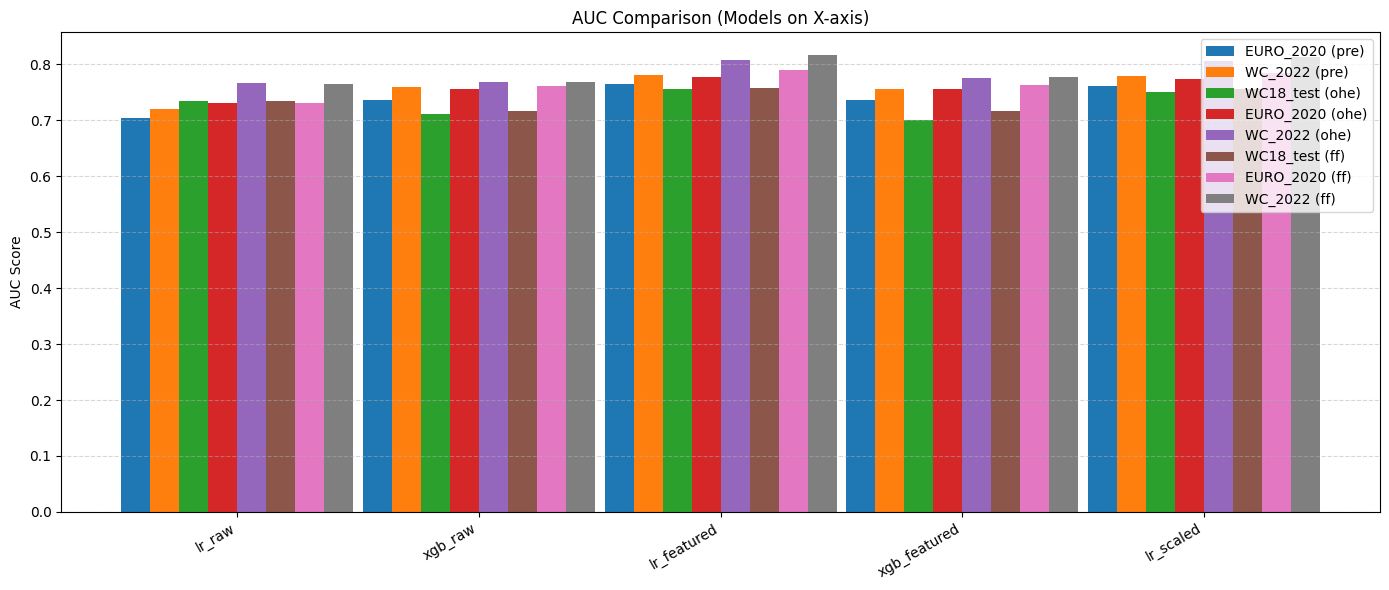

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Models on x-axis
models = ["lr_raw", "xgb_raw", "lr_featured", "xgb_featured", "lr_scaled"]
x = np.arange(len(models))  # positions

# Build legend labels from dataset + stage
legend_labels = auc_df["Dataset"] + " (" + auc_df["Stage"] + ")"
num_datasets = len(legend_labels)

bar_width = 0.12

plt.figure(figsize=(14, 6))

for i in range(num_datasets):
    plt.bar(
        x + i * bar_width,
        auc_df.loc[i, models],
        width=bar_width,
        label=legend_labels[i]
    )

plt.xticks(x + bar_width * (num_datasets - 1) / 2, models, rotation=30, ha="right")
plt.ylabel("AUC Score")
plt.title("AUC Comparison (Models on X-axis)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


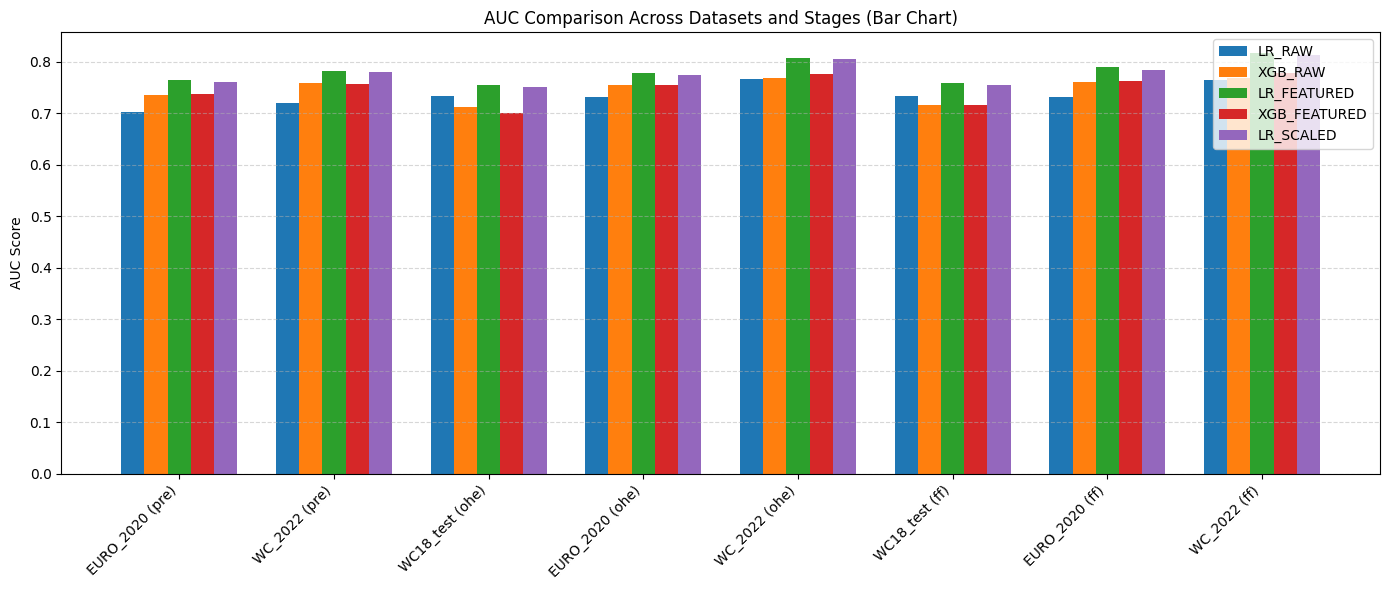

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Build x-axis labels: "WC18_test (pre)"
labels = auc_df["Dataset"] + " (" + auc_df["Stage"] + ")"
x = np.arange(len(labels))  # positions

model_list = ["lr_raw", "xgb_raw", "lr_featured", "xgb_featured", "lr_scaled"]
num_models = len(model_list)

bar_width = 0.15  # width of each bar
plt.figure(figsize=(14, 6))

for i, model in enumerate(model_list):
    plt.bar(
        x + i * bar_width,
        auc_df[model],
        width=bar_width,
        label=model.upper()
    )

plt.xticks(x + bar_width * (num_models-1)/2, labels, rotation=45, ha="right")
plt.ylabel("AUC Score")
plt.title("AUC Comparison Across Datasets and Stages (Bar Chart)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


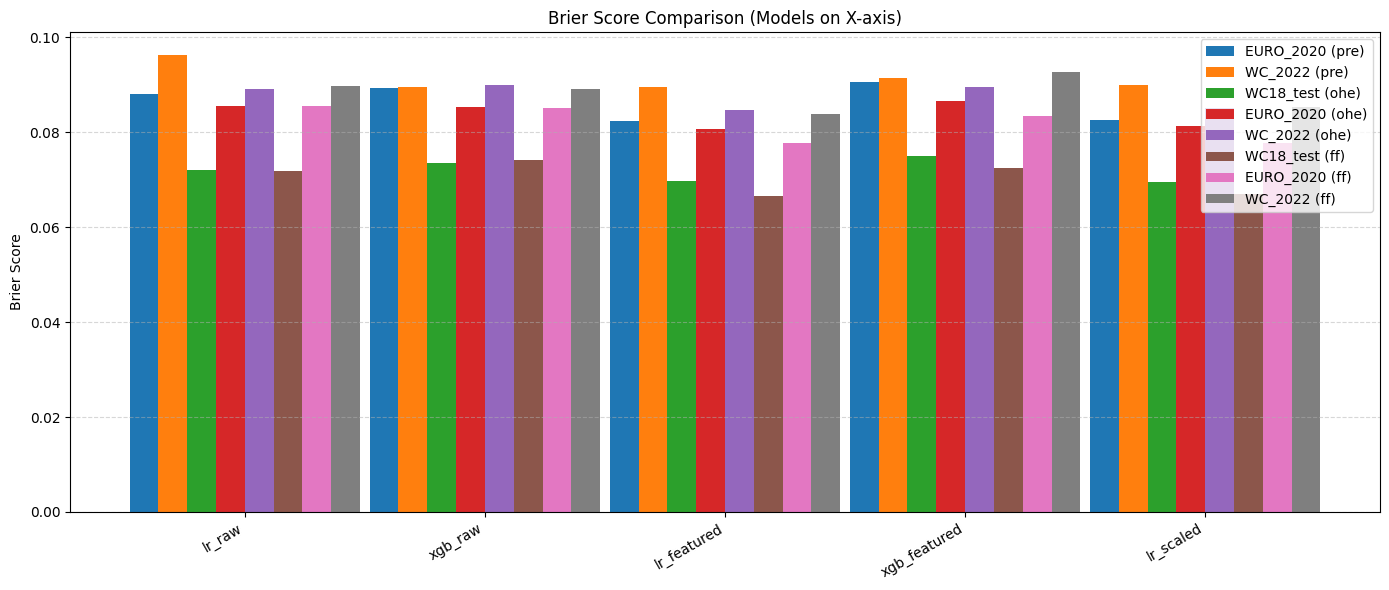

In [74]:
# Models on x-axis
models = ["lr_raw", "xgb_raw", "lr_featured", "xgb_featured", "lr_scaled"]
x = np.arange(len(models))

# Legend labels: "EURO_2020 (pre)" etc.
legend_labels = brier_df["Dataset"] + " (" + brier_df["Stage"] + ")"
num_datasets = len(legend_labels)

bar_width = 0.12

plt.figure(figsize=(14, 6))

for i in range(num_datasets):
    plt.bar(
        x + i * bar_width,
        brier_df.loc[i, models],
        width=bar_width,
        label=legend_labels[i]
    )

plt.xticks(x + bar_width * (num_datasets - 1) / 2, models, rotation=30, ha="right")
plt.ylabel("Brier Score")
plt.title("Brier Score Comparison (Models on X-axis)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


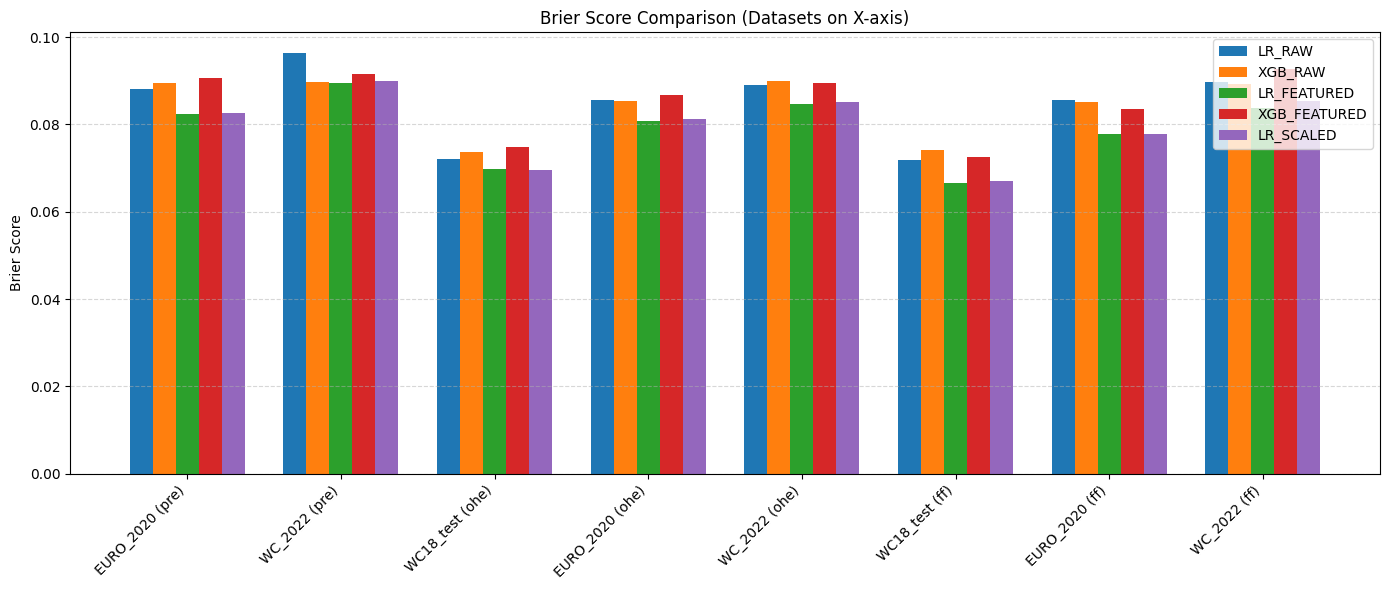

In [76]:

# Dataset labels on x-axis
labels = brier_df["Dataset"] + " (" + brier_df["Stage"] + ")"
x = np.arange(len(labels))

# Models will be the legend
models = ["lr_raw", "xgb_raw", "lr_featured", "xgb_featured", "lr_scaled"]
num_models = len(models)

bar_width = 0.15

plt.figure(figsize=(14, 6))

for i, model in enumerate(models):
    plt.bar(
        x + i * bar_width,
        brier_df[model],
        width=bar_width,
        label=model.upper()
    )

plt.xticks(x + bar_width * (num_models - 1) / 2, labels, rotation=45, ha="right")
plt.ylabel("Brier Score")
plt.title("Brier Score Comparison (Datasets on X-axis)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


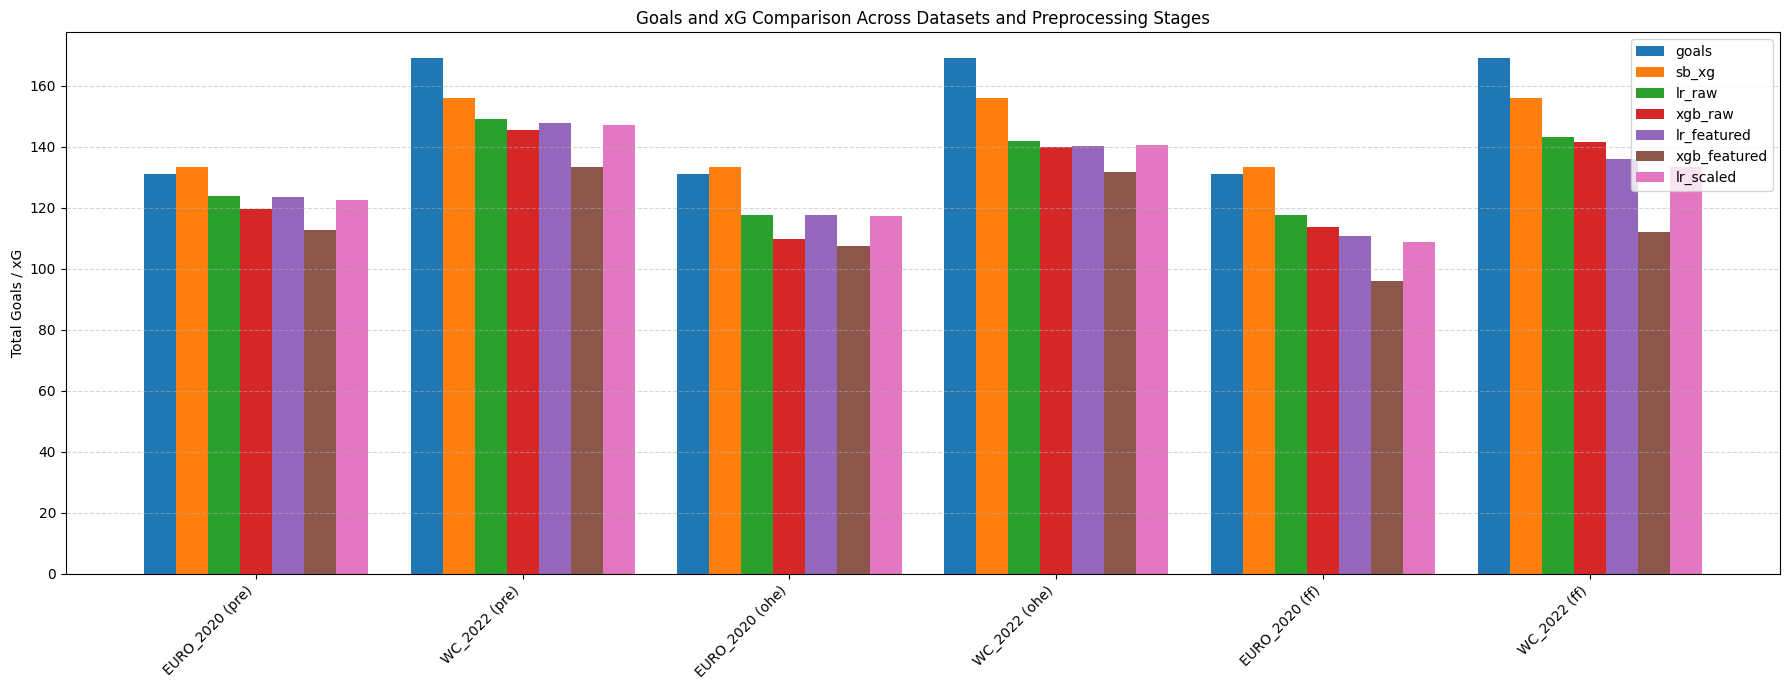

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Build full x-axis labels
labels = xg_df["Dataset"] + " (" + xg_df["Stage"] + ")"
x = np.arange(len(labels))

# Metrics (must match your DF exactly)
metrics = ["goals", "sb_xg", "lr_raw", "xgb_raw", "lr_featured", "xgb_featured", "lr_scaled"]
num_metrics = len(metrics)

bar_width = 0.12

plt.figure(figsize=(18, 7))

for i, metric in enumerate(metrics):
    plt.bar(
        x + i * bar_width,
        xg_df[metric],
        width=bar_width,
        label=metric
    )

plt.xticks(x + bar_width * (num_metrics - 1) / 2, labels, rotation=45, ha="right")
plt.ylabel("Total Goals / xG")
plt.title("Goals and xG Comparison Across Datasets and Preprocessing Stages")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### Grid Search (Hyper-Parameter Tuning for LR on OHE and FF Data Set)

In [80]:

from sklearn.model_selection import GridSearchCV


param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 5, 10],
    "penalty": ["l1", "l2", "elasticnet"],
    "solver": ["saga"],              # Supports all penalties + sparse
    "l1_ratio": [0, 0.5, 1],         # Used only for elasticnet, ignored otherwise
    "class_weight": [None, "balanced"],
    "max_iter": [5000]
}

grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_feat, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

# Save tuned model
lr_tuned = grid.best_estimator_


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'l1_ratio': 0, 'max_iter': 5000, 'penalty': 'elasticnet', 'solver': 'saga'}
Best CV AUC: 0.8064091080552794


In [82]:
from sklearn.metrics import roc_auc_score, brier_score_loss

def evaluate_lr_tuned(name, X, y, df=None):
    preds = lr_tuned.predict_proba(X)[:, 1]

    auc = roc_auc_score(y, preds)
    brier = brier_score_loss(y, preds)

    print(f"\n=== {name} — LR TUNED (FF+OHE) ===")
    print(f"AUC:   {auc:.4f}")
    print(f"Brier: {brier:.4f}")

    totals = {}
    if df is not None:
        goals = df["is_goal"].sum()
        pred_xg = preds.sum()
        print("\nTotals:")
        print("Goals:", goals)
        print("Pred xG:", pred_xg)
        if "shot_statsbomb_xg" in df.columns:
            sb_xg = df["shot_statsbomb_xg"].sum()
            print("StatsBomb xG:", sb_xg)
            totals["sb_xg"] = sb_xg
        totals["goals"] = goals
        totals["lr_tuned"] = pred_xg

    return auc, brier, totals


In [83]:
dataset = "WC18_test"
if dataset not in all_auc[stage]:
    all_auc[stage][dataset] = {}
if dataset not in all_brier[stage]:
    all_brier[stage][dataset] = {}
# usually no xg totals for WC18_test, but we can skip or add if you want

auc, brier, _ = evaluate_lr_tuned("WC18 test split", X_test_feat, y_test, df=None)

all_auc[stage][dataset]["lr_tuned"] = auc
all_brier[stage][dataset]["lr_tuned"] = brier



=== WC18 test split — LR TUNED (FF+OHE) ===
AUC:   0.7525
Brier: 0.1662


In [84]:
dataset = "EURO_2020"
if dataset not in all_auc[stage]:
    all_auc[stage][dataset] = {}
if dataset not in all_brier[stage]:
    all_brier[stage][dataset] = {}
if dataset not in all_xg[stage]:
    all_xg[stage][dataset] = {}

auc, brier, totals = evaluate_lr_tuned("EURO 2020", X_feat_eu, y_eu, df=shots_euro_ff_enc)

all_auc[stage][dataset]["lr_tuned"] = auc
all_brier[stage][dataset]["lr_tuned"] = brier
all_xg[stage][dataset].update(totals)



=== EURO 2020 — LR TUNED (FF+OHE) ===
AUC:   0.7786
Brier: 0.1656

Totals:
Goals: 131
Pred xG: 469.3068342892084
StatsBomb xG: 133.39686355240002


In [85]:
dataset = "WC_2022"
if dataset not in all_auc[stage]:
    all_auc[stage][dataset] = {}
if dataset not in all_brier[stage]:
    all_brier[stage][dataset] = {}
if dataset not in all_xg[stage]:
    all_xg[stage][dataset] = {}

auc, brier, totals = evaluate_lr_tuned("WC 2022", X_feat_22, y_22, df=shots_wc22_ff_enc)

all_auc[stage][dataset]["lr_tuned"] = auc
all_brier[stage][dataset]["lr_tuned"] = brier
all_xg[stage][dataset].update(totals)



=== WC 2022 — LR TUNED (FF+OHE) ===
AUC:   0.8066
Brier: 0.1649

Totals:
Goals: 169
Pred xG: 550.3730833056395
StatsBomb xG: 155.8985419302


In [86]:
p = lr_tuned.predict_proba(X_feat_eu)[:, 1]
print("Goal rate (EURO):", y_eu.mean())
print("Avg predicted prob (EURO):", p.mean())


Goal rate (EURO): 0.10471622701838529
Avg predicted prob (EURO): 0.37514535115044634


In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define model
base_lr = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=5000)

# Hyperparameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 5, 10],
}

# GridSearch with calibration-aware scoring
grid = GridSearchCV(
    estimator=base_lr,
    param_grid=param_grid,
    scoring={"auc": "roc_auc", "brier": "neg_brier_score"},
    refit="brier",      # choose model with the BEST Brier score
    cv=5,
    verbose=3,
    n_jobs=-1
)

# Fit on WC18 training set (FEATURED+FF+OHE)
grid.fit(X_train_feat, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV Brier (neg):", grid.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'C': 1}
Best CV Brier (neg): -0.06845426182734286


In [88]:
lr_tuned = grid.best_estimator_


In [89]:
from sklearn.metrics import roc_auc_score, brier_score_loss

def evaluate_dataset(name, X, y, df=None):
    print(f"\n=== {name} — LR TUNED ===")
    
    preds = lr_tuned.predict_proba(X)[:, 1]
    
    auc  = roc_auc_score(y, preds)
    brier = brier_score_loss(y, preds)
    
    print(f"AUC:   {auc:.4f}")
    print(f"Brier: {brier:.4f}")
    
    if df is not None:
        total_xg = preds.sum()
        goals = df["is_goal"].sum()
        sb_xg = df["shot_statsbomb_xg"].sum()
        
        print("\nTotals:")
        print("Goals:       ", goals)
        print("Pred xG:     ", total_xg)
        print("StatsBomb xG:", sb_xg)
    
    return auc, brier, preds.sum()

# WC18 TEST
evaluate_dataset("WC18 Test (FF+OHE)", X_test_feat, y_test)

# EURO 2020
evaluate_dataset("EURO 2020 (FF+OHE)", X_feat_eu, y_eu, df=shots_euro_ff_enc)

# WC 2022
evaluate_dataset("WC 2022 (FF+OHE)", X_feat_22, y_22, df=shots_wc22_ff_enc)



=== WC18 Test (FF+OHE) — LR TUNED ===
AUC:   0.7585
Brier: 0.0666

=== EURO 2020 (FF+OHE) — LR TUNED ===
AUC:   0.7896
Brier: 0.0778

Totals:
Goals:        131
Pred xG:      110.74571650176864
StatsBomb xG: 133.39686355240002

=== WC 2022 (FF+OHE) — LR TUNED ===
AUC:   0.8163
Brier: 0.0838

Totals:
Goals:        169
Pred xG:      135.7954007801544
StatsBomb xG: 155.8985419302


(0.8163353241534407, 0.08378738993463389, 135.7954007801544)

re-add teams to df and check xg per team
